# Temporal Feature Detection Using RNN On UCF101 Dataset

## 1. Prepare

#### Import packages

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # INFO, WARNING, and ERROR messages are not printed
import numpy as np
import pandas as pd
import cv2
import itertools 
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#### Load Paths and Labels

In [11]:
EPOCHS = 300 # let EarlyStopping end training
Video_Width = 80 # width / height should equal 1.333 to maintain aspect ratio
Video_Height = 60
Video_Frames = 10 # select low amount of frame because RNNs suffer from short term memory
N_Features = Video_Width*Video_Height
SEED = 3
DROPOUT = 0.35
BatchSize = 1 # batch size of 1 for better convergence

data = "PlayingInstrument"
location = None
n_Classes = None
if(data == "Sports"):
    location = "D:\\CISC452 - Final Project\\dataset\\UCF101\\Labels\\Sports.txt"
    n_Classes = 50
elif(data == "PlayingInstrument"):
    location = "D:\\CISC452 - Final Project\\dataset\\UCF101\\Labels\\PlayingInstrument.txt"
    n_Classes = 10
elif(data == "HumanHuman"):
    location = "D:\\CISC452 - Final Project\\dataset\\UCF101\\Labels\\HumanHuman.txt"
    n_Classes = 5
elif(data == "BodyMotion"):
    location = "D:\\CISC452 - Final Project\\dataset\\UCF101\\Labels\\BodyMotion.txt"
    n_Classes = 16
elif(data == "HumanObject"):
    location = "D:\\CISC452 - Final Project\\dataset\\UCF101\\Labels\\HumanObject.txt"
    n_Classes = 20
elif(data == "ALL"):
    location = "D:\\CISC452 - Final Project\\dataset\\UCF101\\Labels\\classInd.txt"
    n_Classes = 101
else:
    print("Invalid Entry!")
    raise SystemExit(0)

# read dataset/subset paths
label_data = pd.read_csv(location, sep=' ', header = None)          
label_data.columns = ['index', 'labels']
label_data = label_data.drop(['index'], axis = 1)
print(label_data.head())

# create list of all paths to videos
path = []
for label in label_data.labels.values:
    path.append("D:\\CISC452 - Final Project\\dataset\\UCF101\\Videos\\" + label + "\\")
path[0]

          labels
0   PlayingCello
1     PlayingDaf
2    PlayingDhol
3   PlayingFlute
4  PlayingGuitar


'D:\\CISC452 - Final Project\\dataset\\UCF101\\Videos\\PlayingCello\\'

#### Load Dataset

In [12]:
# preprocesses video; extract frames -> resize -> grayscale -> standardize
def feature_extraction(video_path, width, height, sequence_length):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count / sequence_length), 1)
    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break;
        frame = cv2.resize(frame, (height, width))
        frame = tf.image.rgb_to_grayscale(frame) # (width, height, 3) -> (width, height, 1)
        frame = tf.image.per_image_standardization(frame) # mean 0, variance 1
        frame = tf.squeeze(frame) # (width, height, 1) -> (width, height)
        frames_list.append(frame)
    video_reader.release()
    return frames_list

# loop through all videos in dataset path and extract features
def load_video(datasets):
    global image
    label_index = 0
    labels = []
    images = []
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            video_path = os.path.join(folder, file)
            frames_list = feature_extraction(video_path, Video_Width, Video_Height, Video_Frames)
            images.append(frames_list)
            labels.append(label_index)
        label_index += 1
    return np.array(images, dtype = 'float16'), np.array(labels, dtype = 'int8')

# load
images, labels = load_video(path)
print(images.shape, pd.Series(labels).shape)
# Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.06, random_state = SEED)
# combine features; width, height, greyscale --combine--> features
x_train = tf.reshape(x_train, shape = (x_train.shape[0], Video_Frames, N_Features)) 
x_test = tf.reshape(x_test, shape = (x_test.shape[0], Video_Frames, N_Features))
# display shapes
print(x_train.shape, np.array(y_train).shape, x_test.shape, np.array(y_test).shape)

100%|████████████████████████████████████████████████████████████████████████████████| 161/161 [00:10<00:00, 15.24it/s]


(1428, 10, 80, 60) (1428,)
(1342, 10, 4800) (1342,) (86, 10, 4800) (86,)


## 2. Construct

#### Build Model

In [13]:
CONSTRAINT = None # tf.keras.constraints.MinMaxNorm(min_value= -3.0, max_value=3.0, rate=0.1)
REGULARIZER = tf.keras.regularizers.L2(l2=0.00005) # apply penalty to large weight values

#build
model = Sequential()
model.add(SimpleRNN(64,
                    batch_input_shape = (BatchSize, Video_Frames, N_Features),
                    return_sequences = True,
                    stateful = True,
                    recurrent_dropout = DROPOUT,
                    kernel_regularizer = REGULARIZER,
                    kernel_constraint = CONSTRAINT,
                    kernel_initializer = 'glorot_uniform',
                    recurrent_initializer = 'glorot_uniform',
                    activation = 'softsign'))
model.add(TimeDistributed(Dropout(DROPOUT)))
model.add(SimpleRNN(32,
                    return_sequences = True,
                    stateful = True,
                    recurrent_dropout = DROPOUT,
                    kernel_regularizer = REGULARIZER,
                    kernel_constraint = CONSTRAINT,
                    kernel_initializer = 'glorot_uniform',
                    recurrent_initializer = 'glorot_uniform',
                    activation = 'softsign'))
model.add(TimeDistributed(Dropout(DROPOUT)))
model.add(SimpleRNN(16,
                    return_sequences = True,
                    stateful = True,
                    recurrent_dropout = DROPOUT,
                    kernel_regularizer = REGULARIZER,
                    kernel_constraint = CONSTRAINT,
                    kernel_initializer = 'glorot_uniform',
                    recurrent_initializer = 'glorot_uniform',
                    activation = 'softsign'))
model.add(TimeDistributed(Dropout(DROPOUT)))
model.add(Flatten())
model.add(Dense(n_Classes,
                kernel_regularizer = REGULARIZER,
                kernel_constraint = CONSTRAINT,
                kernel_initializer = 'glorot_uniform',
                activation = 'softmax'))
#compile
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (1, 10, 64)               311360    
                                                                 
 time_distributed_3 (TimeDis  (1, 10, 64)              0         
 tributed)                                                       
                                                                 
 simple_rnn_4 (SimpleRNN)    (1, 10, 32)               3104      
                                                                 
 time_distributed_4 (TimeDis  (1, 10, 32)              0         
 tributed)                                                       
                                                                 
 simple_rnn_5 (SimpleRNN)    (1, 10, 16)               784       
                                                                 
 time_distributed_5 (TimeDis  (1, 10, 16)             

#### Train Model

In [14]:
es = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', restore_best_weights = True)
history = model.fit(x_train, 
                    to_categorical(y_train),
                    batch_size = BatchSize,
                    epochs = EPOCHS,
                    validation_data = (x_test, to_categorical(y_test)),
                    callbacks = [es])

Epoch 1/300
1342/1342 [==============================] - 26s 17ms/step - loss: 2.3020 - accuracy: 0.1788 - val_loss: 1.9328 - val_accuracy: 0.2442
Epoch 2/300
1342/1342 [==============================] - 23s 17ms/step - loss: 2.0633 - accuracy: 0.2809 - val_loss: 1.7084 - val_accuracy: 0.3605
Epoch 3/300
1342/1342 [==============================] - 22s 17ms/step - loss: 1.8171 - accuracy: 0.3920 - val_loss: 1.4927 - val_accuracy: 0.5116
Epoch 4/300
1342/1342 [==============================] - 23s 17ms/step - loss: 1.5478 - accuracy: 0.5000 - val_loss: 1.3043 - val_accuracy: 0.6047
Epoch 5/300
1342/1342 [==============================] - 23s 17ms/step - loss: 1.3742 - accuracy: 0.5626 - val_loss: 1.2042 - val_accuracy: 0.6512
Epoch 6/300
1342/1342 [==============================] - 24s 18ms/step - loss: 1.1968 - accuracy: 0.6259 - val_loss: 1.0728 - val_accuracy: 0.6395
Epoch 7/300
1342/1342 [==============================] - 23s 17ms/step - loss: 0.9776 - accuracy: 0.6870 - val_loss: 1

## 3. Evaluate

#### Graph

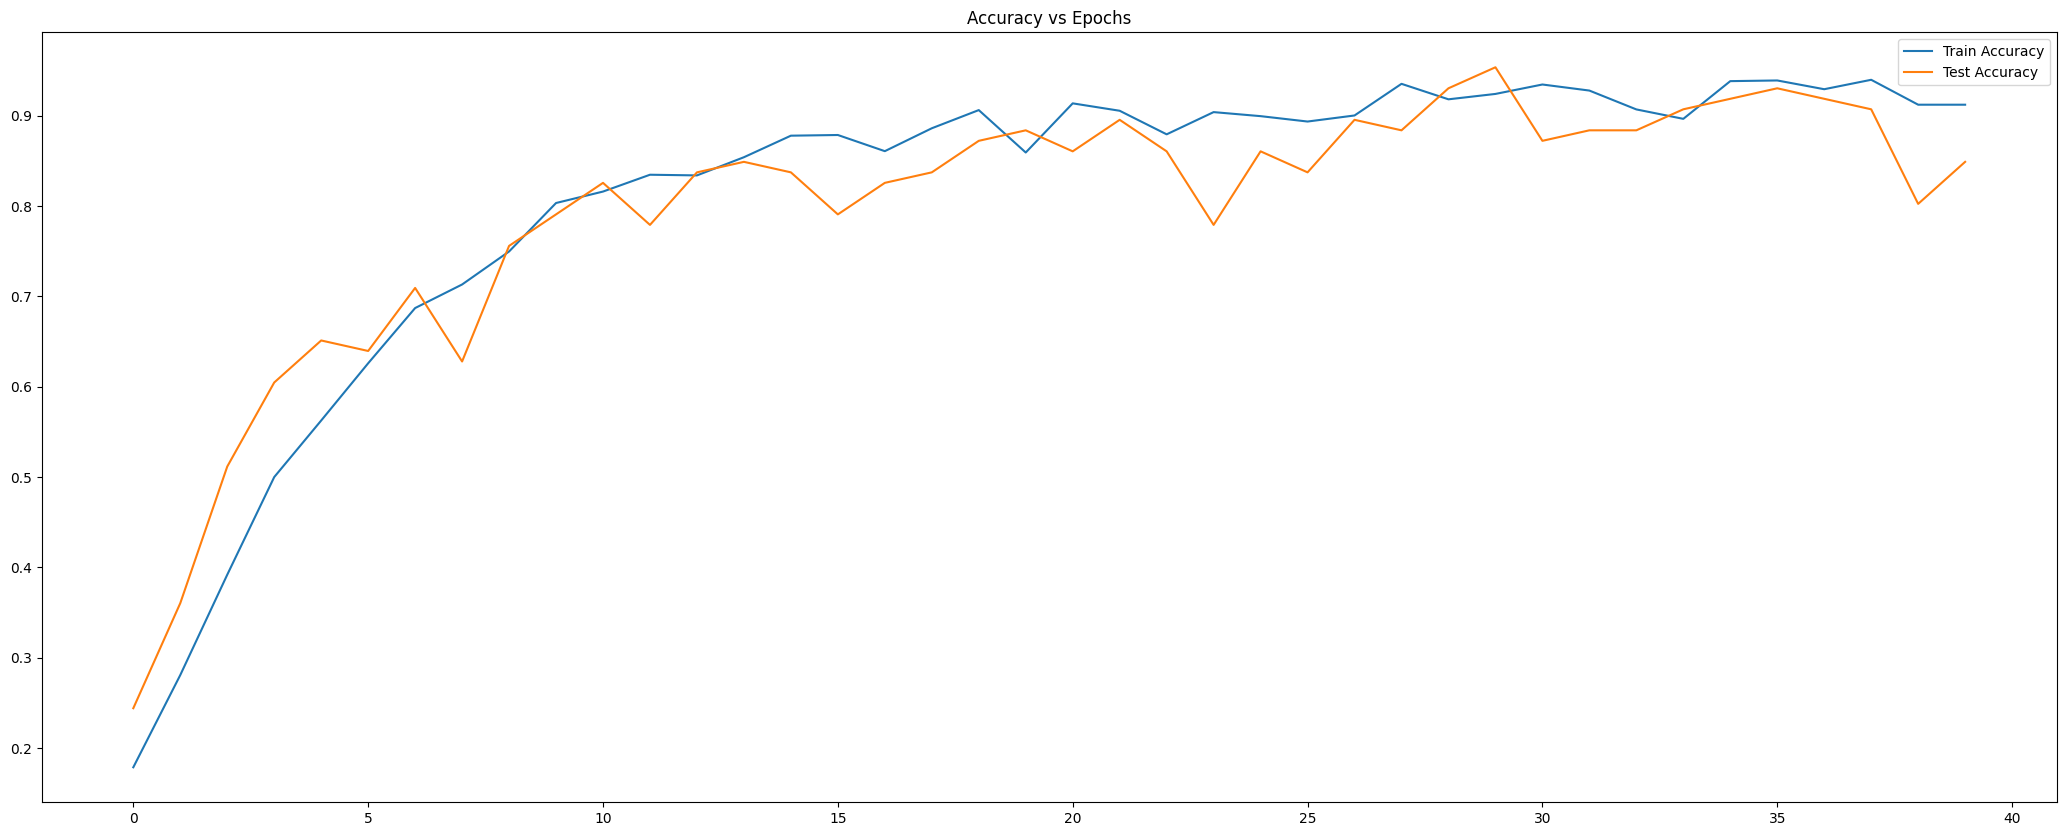

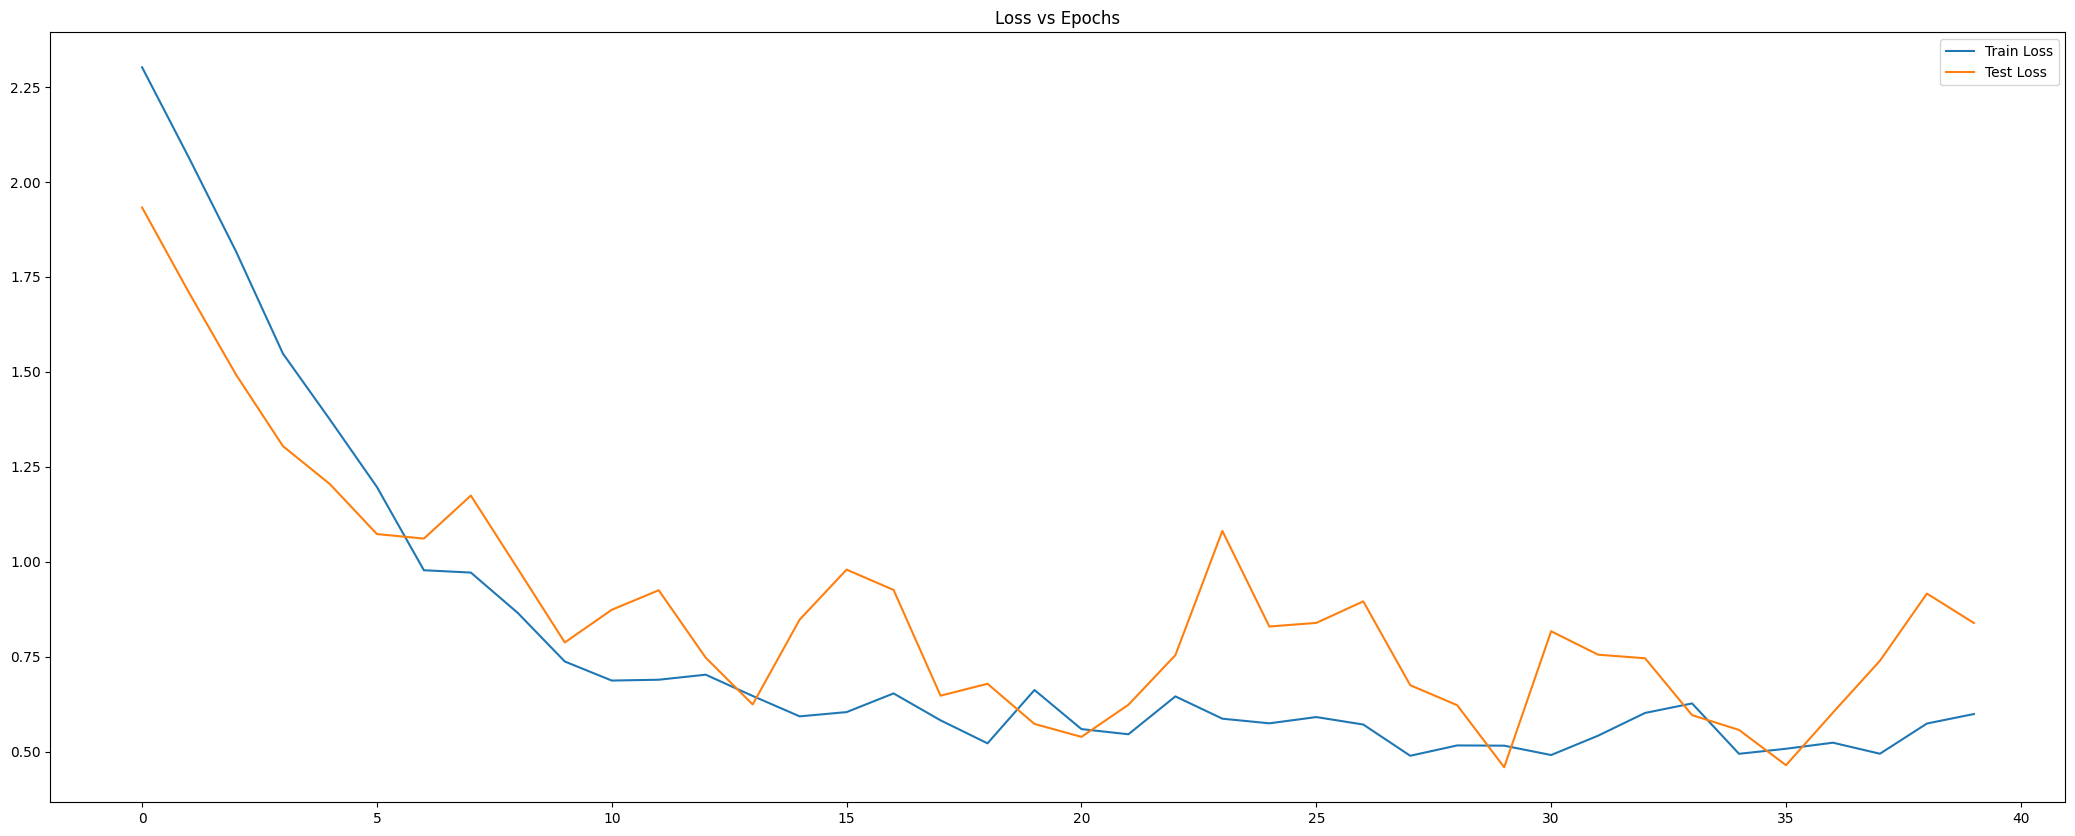

In [15]:
plt.figure(figsize=(26, 10))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.legend(loc = 'best')
plt.show()

plt.figure(figsize=(26, 10))
plt.title("Loss vs Epochs")
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend(loc = 'best')
plt.show()

#### Accuracy

In [16]:
y_pred = model.predict(x_test, batch_size = BatchSize)
predicted_classes = []
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
acc = accuracy_score(y_test, predicted_classes)
print("Validation Accuracy: ", acc)

86/86 [==============================] - 1s 3ms/step
Validation Accuracy:  0.9534883720930233


#### Save Best

In [17]:
if(data == "Sports"):
    print("Saving New Best...")
    model.save("D:\\CISC452 - Final Project\\code\\RNN_Model_Sports.h5")
elif(data == "PlayingInstrument" and acc > 0.9):
    print("Saving New Best...")
    model.save("D:\\CISC452 - Final Project\\code\\RNN_Model_PlayingInstrument.h5")
elif(data == "HumanHuman" and acc > 0.9):
    print("Saving New Best...")
    model.save("D:\\CISC452 - Final Project\\code\\RNN_Model_HumanHuman.h5")
elif(data == "BodyMotion" and acc > 0.9):
    print("Saving New Best...")
    model.save("D:\\CISC452 - Final Project\\code\\RNN_Model_BodyMotion.h5")
elif(data == "HumanObject" and acc > 0.9):
    print("Saving New Best...")
    model.save("D:\\CISC452 - Final Project\\code\\RNN_Model_HumanObject.h5")
elif(data == "ALL" and acc > 0.9):
    print("Saving New Best...")
    model.save("D:\\CISC452 - Final Project\\code\\RNN_Model.h5")
else:
    print("No New Best :(")

Saving New Best...


#### Confusion Matrix

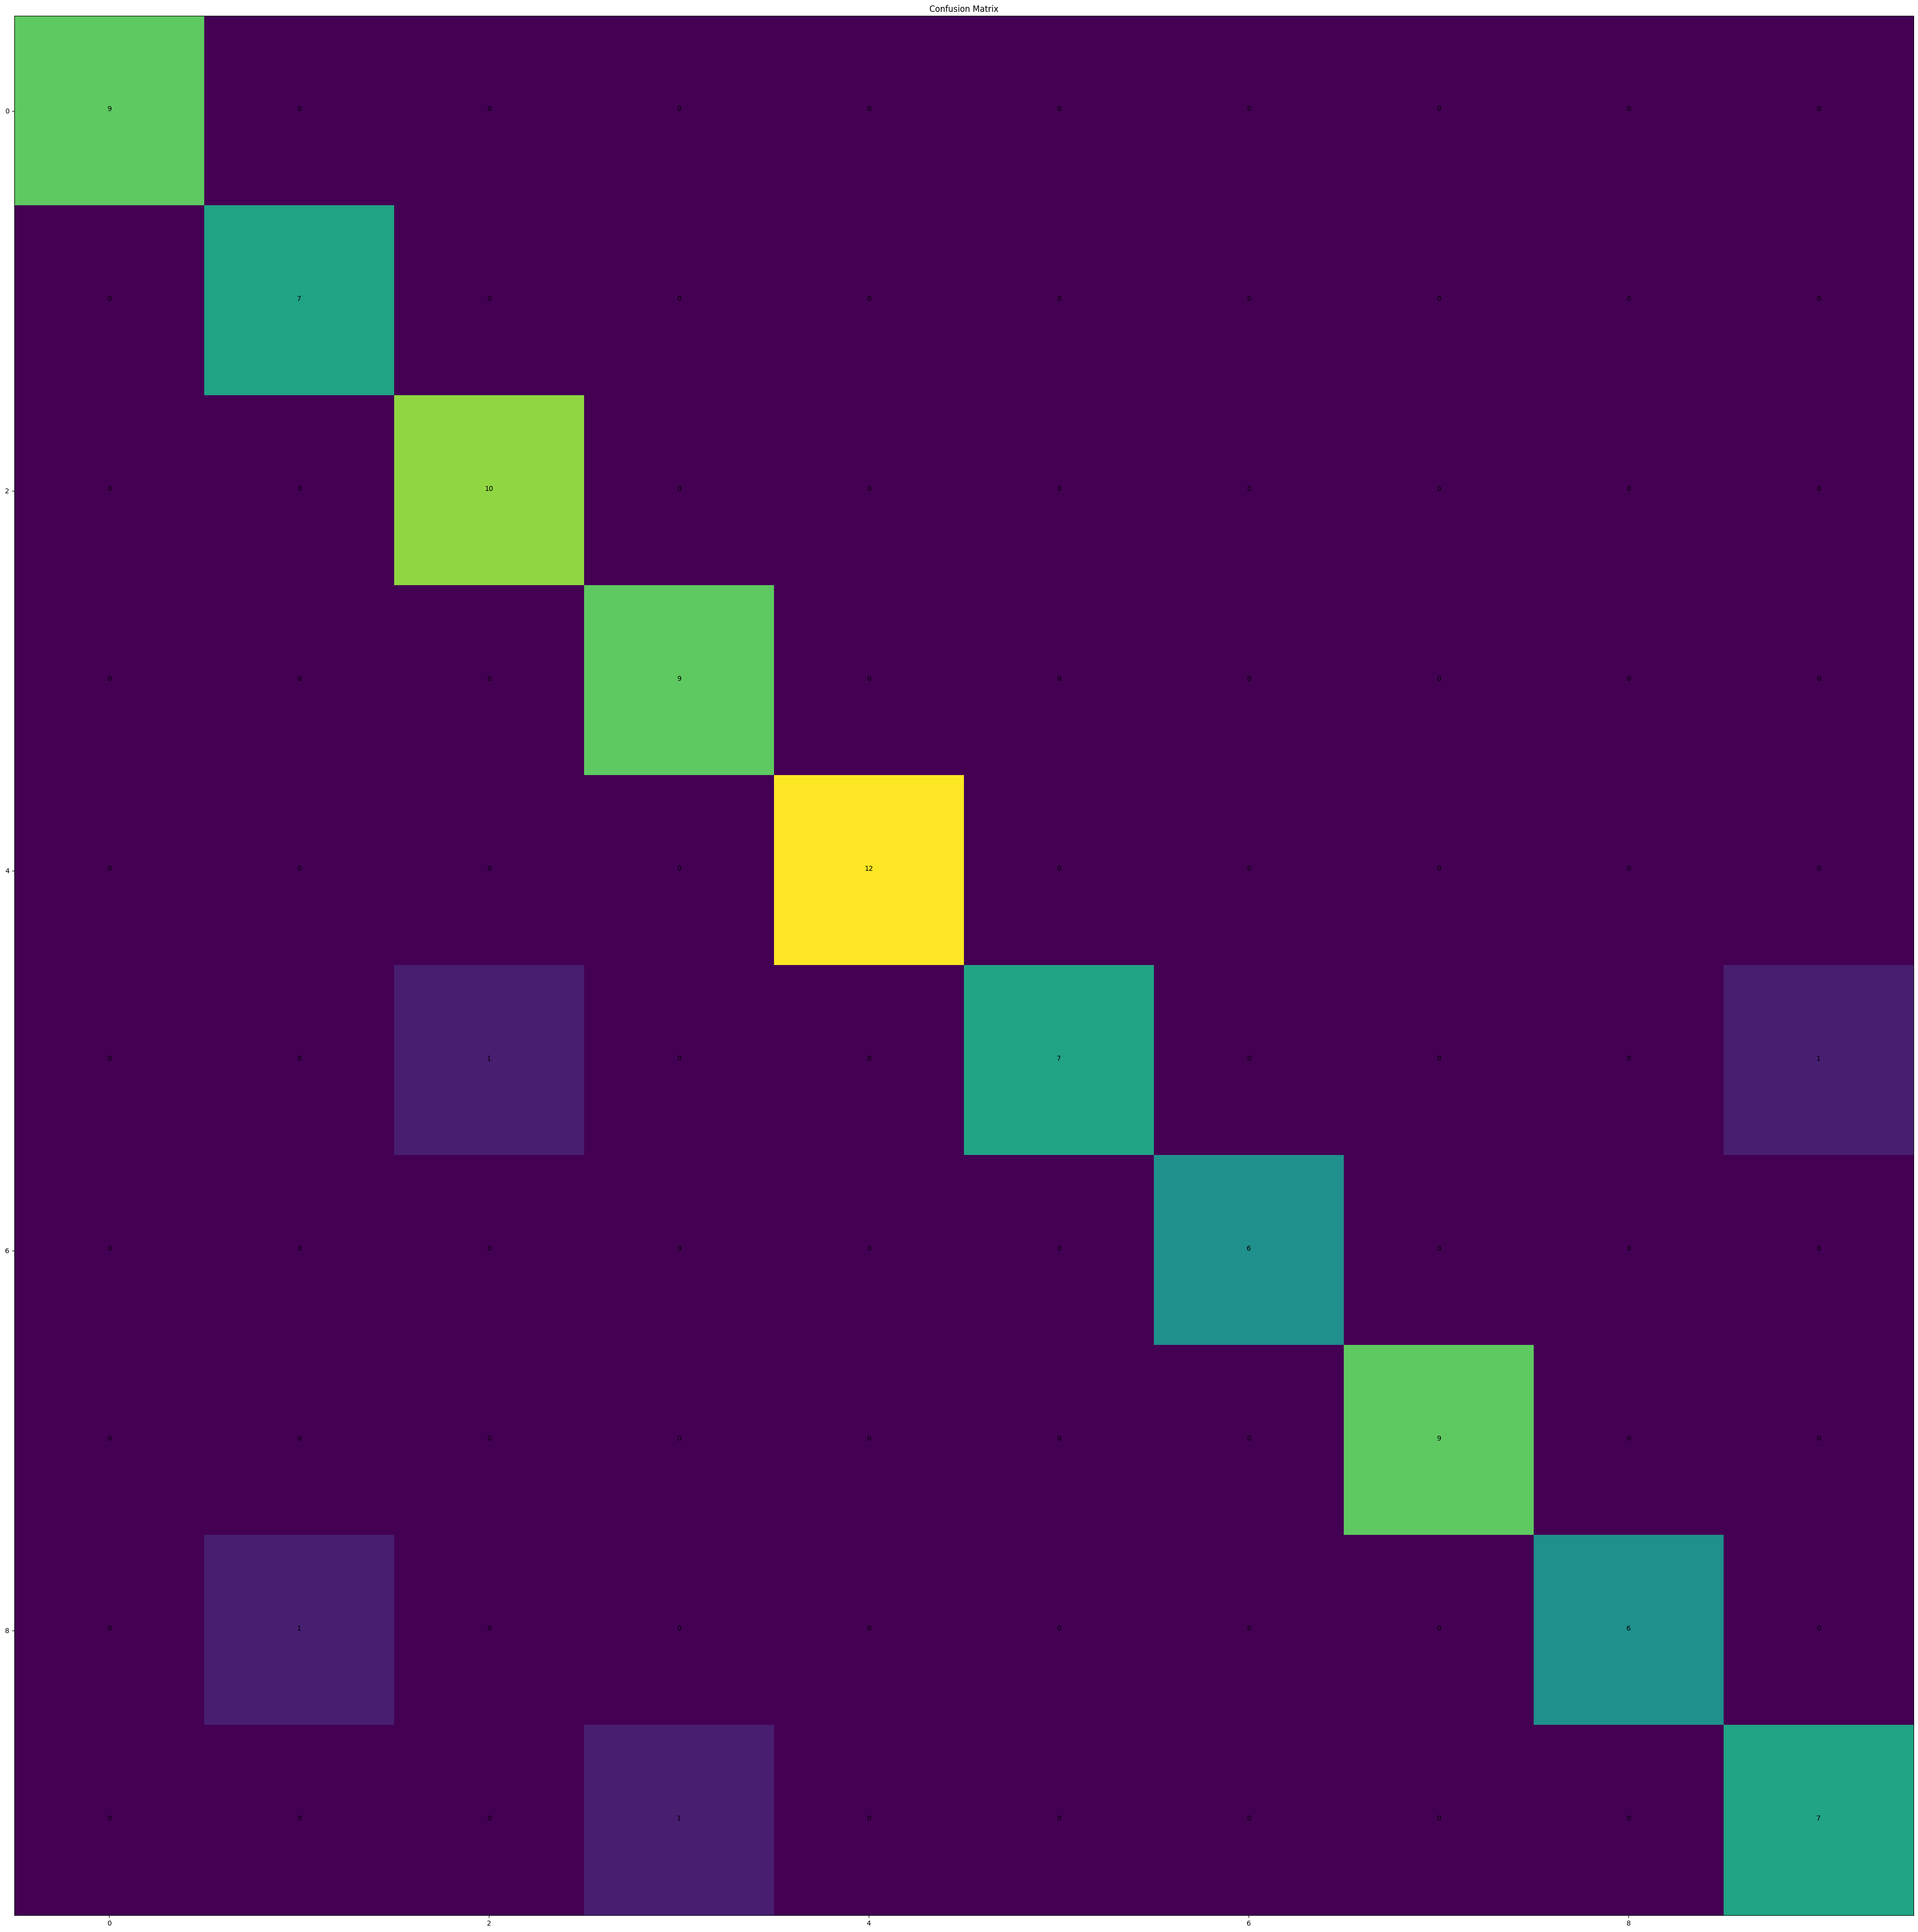

In [18]:
plt.figure(figsize = (50, 50))
plt.title("Confusion Matrix")
cm = confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = "center")
plt.show()